In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler 
%matplotlib inline

## Load and preprocess data

In [2]:
def convert_vix_to_global(date):
    sp = date.split("/")
   
    if len(sp[0]) == 1:
        sp[0] = "".join(["0",sp[0]])
    if len(sp[1]) == 1:
        sp[1] = "".join(["0",sp[1]])
        
    return int("".join([sp[2],sp[0],sp[1]]))

In [3]:
#Load each day's closing prices
dataset = pd.read_csv("Data/EURUSD_min.csv",names=["Date","EURUSD"])
dataset = dataset[dataset["Date"]>20040101]

read_data = pd.read_csv("Data/EURCAD_min.csv", names=["Date","EURCAD"])
dataset = pd.merge(dataset,read_data,how="inner",left_on="Date",right_on="Date")

read_data = pd.read_csv("Data/GBPUSD_min.csv", names=["Date","GBPUSD"])
dataset = pd.merge(dataset,read_data,how="inner",left_on="Date",right_on="Date")

In [4]:
# Load financial indices
read_data = pd.read_csv("Data/BSESN.csv")
read_data['Date'] = read_data['Date'].apply(lambda date: int("".join(date.split('-'))))
dataset = dataset.merge(read_data[["Date","Close"]],how="left",left_on="Date",right_on="Date").rename(columns={"Close":"BSESN"})

read_data = pd.read_csv("Data/HSI.csv")
read_data['Date'] = read_data['Date'].apply(lambda date: int("".join(date.split('-'))))
dataset = dataset.merge(read_data[["Date","Close"]],how="left",left_on="Date",right_on="Date").rename(columns={"Close":"HSI"})

read_data = pd.read_csv("Data/NASDAQCOM.csv")
read_data['DATE'] = read_data['DATE'].apply(lambda date: int("".join(date.split('-'))))
read_data['NASDAQCOM'] = read_data['NASDAQCOM'].apply(lambda x: np.nan if x=="." else x)
read_data['NASDAQCOM'] = read_data['NASDAQCOM'].apply(lambda x: float(x))
dataset = pd.merge(dataset,read_data,how="left",left_on="Date",right_on="DATE")\
.rename(columns={"NASDAQCOM":"NASDAQ"}).drop("DATE",axis=1)

read_data = pd.read_csv("Data/Nikkei225.csv")
read_data['Date'] = read_data['Date'].apply(lambda date: int("".join(date.split('-'))))
dataset = pd.merge(dataset,read_data[["Date","Close"]],how="left",left_on="Date",right_on="Date").rename(columns={"Close":"Nikkei225"})

read_data = pd.read_csv("Data/NYSE.csv")
read_data['Date'] = read_data['Date'].apply(lambda date: int("".join(date.split('-'))))
dataset = pd.merge(dataset,read_data[["Date","Close"]],how="left",left_on="Date",right_on="Date").rename(columns={"Close":"NYSE"})

read_data = pd.read_csv("Data/vixcurrent.csv")
read_data['Date'] = read_data['Date'].apply(convert_vix_to_global)
dataset = pd.merge(dataset,read_data[["Date","VIX Close"]],how="left",left_on="Date",right_on="Date").rename(columns={"VIX Close":"VIX"})

In [5]:
# Fill NaN columns with rolling median (window: 10 items)
columns_to_fill = ["BSESN","HSI","NASDAQ","Nikkei225","NYSE","VIX"]
for col in columns_to_fill:
    dataset[col].fillna(pd.Series(dataset[col].rolling(11,min_periods=1).median()),inplace=True)

In [6]:
# Add monthly LIBOR rates for each month
read_data = pd.read_csv("Data/historical-libor-rates-chart.csv",names=["Date","1month","3month","6month","12month"])
read_data['Date'] = read_data['Date'].apply(lambda date: int("".join([date.split('-')[0],date.split('-')[1]])))
read_data = read_data[read_data["Date"]>200312].reset_index()
read_data.set_index("Date",inplace=True)
libor_rates = read_data[["3month"]].to_dict('index')
libor_rates = {k:v["3month"] for (k,v) in libor_rates.items()}
libor_rates[201508] = 0.32 
dataset["LIBOR"] = pd.DataFrame([libor_rates[int(record["Date"]/100)] for _,record in dataset.iterrows()])

In [7]:
# Use return log of forex prices instead of raw amounts
initial_price = dataset["EURUSD"][0]
dataset["EURUSD"] = dataset["EURUSD"].apply(lambda x: math.log(x/initial_price))

initial_price = dataset["EURCAD"][0]
dataset["EURCAD"] = dataset["EURCAD"].apply(lambda x: math.log(x/initial_price))

initial_price = dataset["GBPUSD"][0]
dataset["GBPUSD"] = dataset["GBPUSD"].apply(lambda x: math.log(x/initial_price))

## Add stock indicators

In [8]:
# Create 7 and 21 days Moving Average
dataset['ma7'] = dataset['EURUSD'].rolling(window=7).mean()
dataset['ma21'] = dataset['EURUSD'].rolling(window=21).mean()

# Create MACD
dataset["26ema"] = dataset['EURUSD'].ewm(span=26).mean()
dataset["12ema"] = dataset['EURUSD'].ewm(span=12).mean()
dataset['MACD'] = (dataset["12ema"]-dataset["26ema"])

#Create Bollinger Bands
dataset['20sd'] = dataset['EURUSD'].rolling(20).std()
dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] *2)
dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] *2)

# Create Exponential moving average
dataset['ema'] = dataset['EURUSD'].ewm(com=0.5).mean()

# Create Momentum
dataset['momentum'] = dataset['EURUSD']-1

In [14]:
dataset.dropna(inplace=True)

## Fast Fourier Transforms for Trend Detection

/home/dark0ne/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


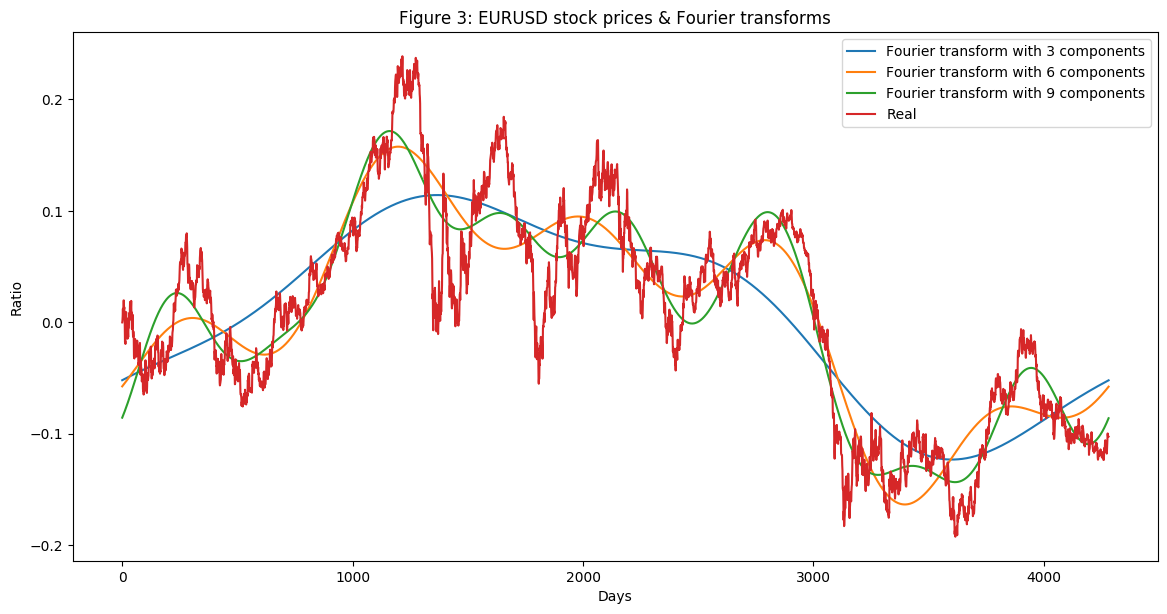

In [9]:
data_FT = dataset[['Date', 'EURUSD']]
close_fft = np.fft.fft(np.asarray(data_FT['EURUSD'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    dataset = pd.concat([dataset,pd.Series(np.real(np.fft.ifft(fft_list_m10))).rename("trend{}".format(num_))],axis=1)
plt.plot(data_FT['EURUSD'],  label='Real')
plt.xlabel('Days')
plt.ylabel('Ratio')
plt.title('Figure 3: EURUSD stock prices & Fourier transforms')
plt.legend()
plt.show()

## Normalize all columns 

In [11]:
scaler = MinMaxScaler()
columns = ["BSESN","HSI","NASDAQ","Nikkei225","NYSE","VIX","ma7","ma21","26ema","12ema","MACD","20sd","upper_band","lower_band","ema","momentum","trend3","trend6","trend9"]
for col in columns:
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

In [16]:
export_csv = dataset.to_csv (r'processed_EURUSD.csv', index = None, header=True)

In [15]:
dataset

,Date,EURUSD,EURCAD,GBPUSD,BSESN,HSI,NASDAQ,Nikkei225,NYSE,VIX,...,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,trend3,trend6,trend9
20,20040126,-0.009576,0.010182,0.011646,0.039958,0.125442,0.128415,0.227562,0.263029,0.075303,...,0.442585,0.517794,0.222178,0.462764,0.435883,0.432113,0.423835,0.309041,0.346810,0.218429
21,20040127,0.003488,0.016448,0.019171,0.041605,0.127015,0.122933,0.224973,0.259559,0.086459,...,0.444535,0.527064,0.222165,0.463156,0.436283,0.447555,0.454150,0.309486,0.347668,0.220287
22,20040128,-0.007654,0.020443,0.016377,0.038333,0.112010,0.117323,0.220584,0.250546,0.106401,...,0.441953,0.520871,0.226898,0.463086,0.434270,0.435346,0.428296,0.309930,0.348527,0.222156
23,20040129,-0.014641,0.017297,0.012913,0.036284,0.107566,0.115997,0.216342,0.250518,0.111421,...,0.437148,0.507746,0.233798,0.462247,0.430595,0.420392,0.412083,0.310374,0.349389,0.224034
24,20040130,-0.009416,0.017842,0.017857,0.033289,0.105536,0.115695,0.216584,0.250079,0.104309,...,0.435072,0.504613,0.238013,0.460659,0.427269,0.423546,0.424207,0.310817,0.350251,0.225922
25,20040201,-0.008935,0.019597,0.017364,0.036478,0.118312,0.123363,0.227562,0.258165,0.084507,...,0.433506,0.503332,0.231409,0.457898,0.427203,0.425347,0.425323,0.311259,0.351115,0.227820
26,20040202,-0.013191,0.024181,0.014674,0.036284,0.092382,0.115260,0.216184,0.251915,0.111003,...,0.430592,0.497447,0.213141,0.451145,0.427909,0.419317,0.415447,0.311701,0.351981,0.229727
27,20040203,-0.004697,0.032929,0.024683,0.031201,0.096474,0.115704,0.208354,0.252573,0.114210,...,0.431313,0.504457,0.182059,0.442039,0.431508,0.430539,0.435157,0.312143,0.352849,0.231644
28,20040204,-0.004777,0.029343,0.022067,0.034998,0.096325,0.108150,0.197046,0.247333,0.121601,...,0.431891,0.510369,0.164434,0.435670,0.432337,0.434155,0.434972,0.312584,0.353717,0.233569
29,20040205,-0.004298,0.033645,0.022067,0.033987,0.093789,0.108936,0.198054,0.249289,0.119370,...,0.432557,0.516089,0.138990,0.428627,0.435696,0.436106,0.436083,0.313024,0.354587,0.235503
